In [19]:
# !pip install tensorflow numpy matplotlib scipy

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load FER-2013 dataset
def load_fer2013(data_path):
    with open(data_path, 'r') as f:
        lines = f.readlines()[1:]  # Skip header
    images, labels = [], []
    for line in lines:
        emotion, pixels, usage = line.strip().split(',')
        pixels = np.array(pixels.split(), dtype='float32') / 255.0  # Normalize to [0, 1]
        images.append(pixels.reshape(48, 48, 1))  # Reshape to 48x48 grayscale
        labels.append(int(emotion))
    return np.array(images), np.array(labels)

# Load dataset
data_path = 'fer2013.csv'  # Path to your FER-2013 CSV file
images, labels = load_fer2013(data_path)

# Split into training and validation sets
train_images, val_images = images[:30000], images[30000:]
train_labels, val_labels = labels[:30000], labels[30000:]

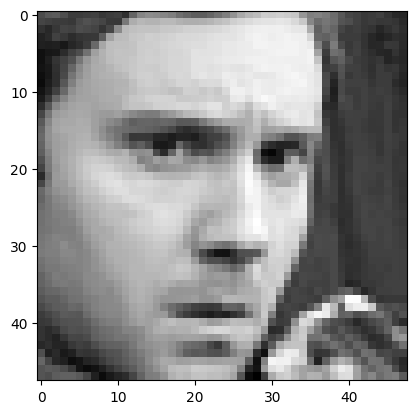

In [8]:
# import matplotlib.pyplot as plt
# plt.imshow(train_images[0].reshape(48, 48), cmap='gray')

In [11]:
# from tensorflow.keras import layers, models

# class CapsuleLayer(layers.Layer):
#     def __init__(self, num_capsules, dim_capsule, routings=3, **kwargs):
#         super(CapsuleLayer, self).__init__(**kwargs)
#         self.num_capsules = num_capsules
#         self.dim_capsule = dim_capsule
#         self.routings = routings

#     def build(self, input_shape):
#         self.input_num_capsules = input_shape[1]
#         self.input_dim_capsule = input_shape[2]
#         self.W = self.add_weight(shape=[self.input_num_capsules, self.num_capsules, self.input_dim_capsule, self.dim_capsule],
#                                  initializer='glorot_uniform', trainable=True)

#     def call(self, inputs):
#         inputs_expanded = tf.expand_dims(inputs, 2)
#         inputs_tiled = tf.tile(inputs_expanded, [1, 1, self.num_capsules, 1, 1])
#         inputs_hat = tf.matmul(inputs_tiled, self.W)

#         b = tf.zeros(shape=[tf.shape(inputs_hat)[0], self.input_num_capsules, self.num_capsules, 1, 1])
#         for i in range(self.routings):
#             c = tf.nn.softmax(b, axis=2)
#             outputs = tf.reduce_sum(c * inputs_hat, axis=1, keepdims=True)
#             if i < self.routings - 1:
#                 b += tf.reduce_sum(inputs_hat * outputs, axis=-1, keepdims=True)
#         return tf.squeeze(outputs, axis=1)

# def build_capsnet(input_shape, num_classes):
#     inputs = layers.Input(shape=input_shape)
#     x = layers.Conv2D(256, (9, 9), activation='relu')(inputs)
#     x = layers.Reshape((-1, 8))(x)  # Primary capsules
#     x = CapsuleLayer(num_capsules=32, dim_capsule=8)(x)  # Capsule layer
#     x = layers.Lambda(lambda z: tf.sqrt(tf.reduce_sum(tf.square(z), axis=-1)))(x)  # Length of capsules
#     outputs = layers.Dense(num_classes, activation='softmax')(x)  # Classification layer
#     model = models.Model(inputs, outputs)
#     return model

# # Build CapsNet model
# input_shape = (48, 48, 1)  # FER-2013 image size
# num_classes = 7  # 7 emotions
# capsnet = build_capsnet(input_shape, num_classes)
# capsnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# capsnet.summary()

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models

class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsules, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        self.input_num_capsules = input_shape[1]  # Number of input capsules
        self.input_dim_capsule = input_shape[2]   # Dimension of input capsules
        # Weight matrix: [input_num_capsules, num_capsules, input_dim_capsule, dim_capsule]
        self.W = self.add_weight(shape=[self.input_num_capsules, self.num_capsules, self.input_dim_capsule, self.dim_capsule],
                                 initializer='glorot_uniform', trainable=True)

    def call(self, inputs):
        inputs_expanded = tf.expand_dims(inputs, axis=2)
        inputs_tiled = tf.tile(inputs_expanded, [1, 1, self.num_capsules, 1])
        inputs_hat = tf.einsum('bijc,jcdk->bijdk', inputs_tiled, self.W)  # Fixed multiplication

        # Routing algorithm
        b = tf.zeros(shape=[tf.shape(inputs_hat)[0], self.input_num_capsules, self.num_capsules, 1])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)
            outputs = tf.reduce_sum(c * inputs_hat, axis=1, keepdims=True)
            if i < self.routings - 1:
                b += tf.reduce_sum(inputs_hat * outputs, axis=-1, keepdims=True)
        
        return tf.squeeze(outputs, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_capsules, self.dim_capsule)

def build_capsnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(256, (9, 9), activation='relu')(inputs)
    
    num_primary_caps = ((input_shape[0] - 9 + 1) * (input_shape[1] - 9 + 1) * 256) // 8
    x = layers.Reshape((num_primary_caps, 8))(x)  # Fixed capsule reshaping
    
    x = CapsuleLayer(num_capsules=32, dim_capsule=8)(x)
    x = layers.Lambda(lambda z: tf.sqrt(tf.reduce_sum(tf.square(z), axis=-1)))(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

# Build CapsNet model
input_shape = (48, 48, 1)
num_classes = 7
capsnet = build_capsnet(input_shape, num_classes)
capsnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
capsnet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 256)    │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 51200, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_layer_5 (CapsuleLayer)  │ (None, 32, 8)          │   104,857,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,878,823 (400.08 MB)

 Trainable params: 104,878,823 (400.08 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# # Data augmentation
# datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# datagen.fit(train_images)

# # Train the model
# batch_size = 32
# epochs = 20
# history = capsnet.fit(datagen.flow(train_images, train_labels, batch_size=batch_size), validation_data=(val_images, val_labels), epochs=epochs)

In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models

class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsules, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        self.input_num_capsules = input_shape[1]  # Number of input capsules
        self.input_dim_capsule = input_shape[2]   # Dimension of input capsules
        # Weight matrix: [input_num_capsules, num_capsules, input_dim_capsule, dim_capsule]
        self.W = self.add_weight(shape=[self.input_num_capsules, self.num_capsules, self.input_dim_capsule, self.dim_capsule],
                                 initializer='glorot_uniform', trainable=True)

    def call(self, inputs):
        # Expand inputs to [batch_size, input_num_capsules, 1, input_dim_capsule]
        inputs_expanded = tf.expand_dims(inputs, axis=2)
        # Tile inputs to [batch_size, input_num_capsules, num_capsules, input_dim_capsule]
        inputs_tiled = tf.tile(inputs_expanded, [1, 1, self.num_capsules, 1])
        # Reshape inputs_tiled to [batch_size, input_num_capsules * num_capsules, input_dim_capsule]
        inputs_tiled = tf.reshape(inputs_tiled, [-1, self.input_num_capsules * self.num_capsules, self.input_dim_capsule])
        # Reshape W to [input_num_capsules * num_capsules, input_dim_capsule, dim_capsule]
        W_reshaped = tf.reshape(self.W, [self.input_num_capsules * self.num_capsules, self.input_dim_capsule, self.dim_capsule])
        # Compute inputs_hat = inputs_tiled * W_reshaped
        inputs_hat = tf.matmul(inputs_tiled, W_reshaped)  # Shape: [batch_size, input_num_capsules * num_capsules, dim_capsule]
        # Reshape inputs_hat back to [batch_size, input_num_capsules, num_capsules, dim_capsule]
        inputs_hat = tf.reshape(inputs_hat, [-1, self.input_num_capsules, self.num_capsules, self.dim_capsule])

        # Routing algorithm
        b = tf.zeros(shape=[tf.shape(inputs_hat)[0], self.input_num_capsules, self.num_capsules, 1])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)  # Shape: [batch_size, input_num_capsules, num_capsules, 1]
            outputs = tf.reduce_sum(c * inputs_hat, axis=1, keepdims=True)  # Shape: [batch_size, 1, num_capsules, dim_capsule]
            if i < self.routings - 1:
                b += tf.reduce_sum(inputs_hat * outputs, axis=-1, keepdims=True)  # Update b
        return tf.squeeze(outputs, axis=1)  # Shape: [batch_size, num_capsules, dim_capsule]

def build_capsnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    # Convolutional layer
    x = layers.Conv2D(256, (9, 9), activation='relu')(inputs)
    # Reshape to [batch_size, num_input_capsules, dim_input_capsule]
    x = layers.Reshape((-1, 8))(x)  # Primary capsules
    # Capsule layer
    x = CapsuleLayer(num_capsules=32, dim_capsule=8)(x)  # Capsule layer
    # Compute the length of capsules
    x = layers.Lambda(lambda z: tf.sqrt(tf.reduce_sum(tf.square(z), axis=-1)))(x)  # Shape: [batch_size, num_capsules]
    # Classification layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Shape: [batch_size, num_classes]
    model = models.Model(inputs, outputs)
    return model

# Build CapsNet model
input_shape = (48, 48, 1)  # FER-2013 image size
num_classes = 7  # 7 emotions
capsnet = build_capsnet(input_shape, num_classes)
capsnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
capsnet.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 40, 40, 256)    │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_12 (Reshape)            │ (None, 51200, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_layer_12 (CapsuleLayer) │ (1638400, 32, 8)       │   104,857,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_7 (Lambda)               │ (1638400, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (1638400, 7)           │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,878,823 (400.08 MB)

 Trainable params: 104,878,823 (400.08 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# # Data augmentation
# datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# datagen.fit(train_images)

# # Train the model
# batch_size = 32
# epochs = 20
# history = capsnet.fit(datagen.flow(train_images, train_labels, batch_size=batch_size),
#                       validation_data=(val_images, val_labels),
#                       epochs=epochs)

# Train the model on original training data without augmentation
batch_size = 32
epochs = 20
history = capsnet.fit(train_images, train_labels, 
                      validation_data=(val_images, val_labels),
                      epochs=epochs, 
                      batch_size=batch_size)

# plt.imshow(train_images[0].reshape(48, 48), cmap='gray')
# train_labels[0]


Epoch 1/20


SystemError: <built-in function len> returned a result with an exception set

In [22]:
# Evaluate on validation set
val_loss, val_accuracy = capsnet.evaluate(val_images, val_labels)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

ValueError: Exception encountered when calling CapsuleLayer.call().

[1mDimensions must be equal, but are 32 and 51200 for '{{node functional_1/capsule_layer_5_1/einsum/Einsum}} = Einsum[N=2, T=DT_FLOAT, equation="bijc,jcdk->bijdk"](functional_1/capsule_layer_5_1/Tile, functional_1/capsule_layer_5_1/einsum/Einsum/ReadVariableOp)' with input shapes: [?,51200,32,8], [51200,32,8,8].[0m

Arguments received by CapsuleLayer.call():
  • inputs=tf.Tensor(shape=(None, 51200, 8), dtype=float32)

In [ ]:
from tensorflow.keras.preprocessing import image

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Predict emotion
img_path = 'test_image.jpg'  # Path to your test image
img_array = preprocess_image(img_path)
prediction = capsnet.predict(img_array)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
predicted_emotion = emotion_labels[np.argmax(prediction)]
print(f"Predicted Emotion: {predicted_emotion}")